<h1><center>Laboratorio 8: Predicciones y Recomendaciones 🔮🪄 </center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### **Cuerpo Docente:**

- **Profesores:** Ignacio Meza, Sebastián Tinoco
- **Auxiliares:** Catherine Benavides, Consuelo Rojas
- **Ayudante:** Nicolás Ojeda, Eduardo Moya

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1: Fabián Palma
- Nombre de alumno 2: Tomás Guzmán  

### **Link de repositorio de GitHub:** `github.com/tomasfabianMDS/LABS`

## Temas a tratar
- Series de Tiempo.
- Predicciones vía `Prophet`.
- Implementar un sistema de recomendación utilizando `surprise`.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio
- Comprender qué es una serie de tiempo y su estructura.
- Identificar tendencias, estacionalidades e irregularidades.
- Armar un modelo predictivo para la serie.
- Conocer y aplicar sistemas de recomendación.
- Entender estructura y conocer casos de estudio.


In [1]:
# Librerias globales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# **Forecasting (3.0 puntos)**


## **Prophet, teoria**

Prophet es una herramienta open-source de Facebook utilizada para realizar predicciones en series de tiempo. Esta se basa en la descomposición aditiva, donde tendencias no lineales se ajustan junto a la estacionalidad.

En la ecuación de a continuación se puede ver una idea general de los elementos que construyen a un modelo aditivo como lo es Prophet.

\begin{equation}
y(t) = g(t) + s(t) + h(t) + e(t)
\end{equation}

Donde, $g(t)$ hace referencia a las tendencias, que corresponden a cambios graduales en largos periodos de tiempo. $s(t)$ corresponde a la estacionalidad, son cambios periodicos o cortos en el tiempo. $h(t)$ es el efecto que tienen las festividades sobre las predicciones, mientras que e(t) corresponde al error o ruido. Finalmente $y(t)$, es la predicción hecha por el modelo.

Prophet trabaja por defecto con Piece-Wise Lineal Model, este es un modelo de regresión lineal, en el cual se buscan distintas zonas en que la data presente patrones o tendencias lineales, de estas zonas obtiene su regresión y luego las "une" de manera de representar toda la región, como se puede ver en la ecuación siguiente.

\begin{equation}
y(x)=
    \begin{cases}
        η_1 + \beta_1(x-b_1), & b_1 < x  \leqslant b_2 \\
        η_2 + \beta_2(x-b_2), & b_2 < x  \leqslant b_3 \\
        η_3 + \beta_3(x-b_3), & b_3 < x  \leqslant b_3 \\
        ... \\
        η_k + \beta_{nb}(x-b_{nb-1}), & b_{n-1} < x  \leqslant b_{nb} \\
    \end{cases}
\end{equation}

Siendo $b_1$ el primer punto de quiebre en la serie y así hasta el punto $b_{nb}$ correspondiente al último punto de quiebre de la serie con una cantidad $nb$ de puntos.

Para mayor información de Prophet y como utilizarla, pueden ver su [documentación](https://facebook.github.io/prophet/docs/quick_start.html#python-api), donde hay pueden encontrar un pequeño tutorial de la librería.

## **Prophet, práctica**

<center>
<img src ="https://static.wikia.nocookie.net/31minutos/images/d/d1/Don_Sergio.png/revision/latest?cb=20190926222900" width = 250 />

Don Sergio quiere entrenar para participar en la maratón y como sabe que correr una maratón requiere de entrenamiento y una dieta balanceada.

Por ello, necesita empezar a comer más balanceado, pero también necesita saber que tanto le va a costar esto, de manera de poder agregarlo a su presupuesto.

Es así como ustedes tendrán que ayudar a Don Sergio a cumplir su sueño de correr la maratón de Santiago, manteniendo su economía del hogar que comparte con su espora Emerilda.

**Datos**

Para poder ayudar a Don Sergio, harán uso del dataset `fruit_vegetables.csv`que contiente las siguientes columnas:

*   `SN:` Serial Number.
*   `Commodity:` Nombre de las frutas o verduras.
* `Date:` Fecha del registro.
* `Unit:` Unidad del precio.
* `Minumum:` Precio mínimo de venta.
* `Maximum:` Precio máximo de venta.
* `Average:` Precio promedio de venta.




In [6]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/Lab_08/datos_lab8'
except:
    print('Ignorando conexión drive-colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Serie de Tiempo**


#### **1.1 Pre-procesamiento**

Tareas de la sección:


1.   Identificar elementos necesarios para generar la serie de tiempo.
2.   Gráficar datos.
3.   Ver la existencia de tendencias, estacionalidades o ruido.
4.   Dividir datos para tener set de entrenamiento (80%) y testeo (20%). Graficar.

---





**Comida de Don Sergio**

Don Sergio quiere nutricer lo mejor posible durante su tiempo de entrenamiento, por lo que necesita agregar más frutas y verduras a su dieta. Es por ello que decidío añadir los siguientes elementos a su compra diaria.

*   Tomates
*   Lechuga
*   Manzana
*   Plantanos
*   Tofu

**Nota:** Don Sergio prefiere comprar productos locales, compra un Kg diario de cada cosa y a precio promedio.

**Respuesta:**

In [7]:
# Leer el dataset
df = pd.read_csv(path+'/fruit_vegetables.csv')

In [8]:
# Crear máscara con elementos de búsqueda y seleccionar
# Filtrar los productos necesarios
products = ['Tomatoes', 'Lechuga', 'Manzana', 'Plantanos', 'Tofu']
mask = df['Commodity'].isin(products)

# Crear un dataframe con los productos filtrados
df_filtered = df[mask]

In [9]:
# Agrupar por fecha en la columna average y sumar, obtener serie de tiempo
# Convertir la columna de fecha a formato datetime
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Agrupar por fecha y sumar los precios promedio
df_filtered_grouped = df_filtered.groupby('Date')['Average'].sum().reset_index()

# Renombrar columnas para Prophet
df_filtered_grouped.rename(columns={'Date': 'ds', 'Average': 'y'}, inplace=True)

<ipython-input-9-49cb7ea1f635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


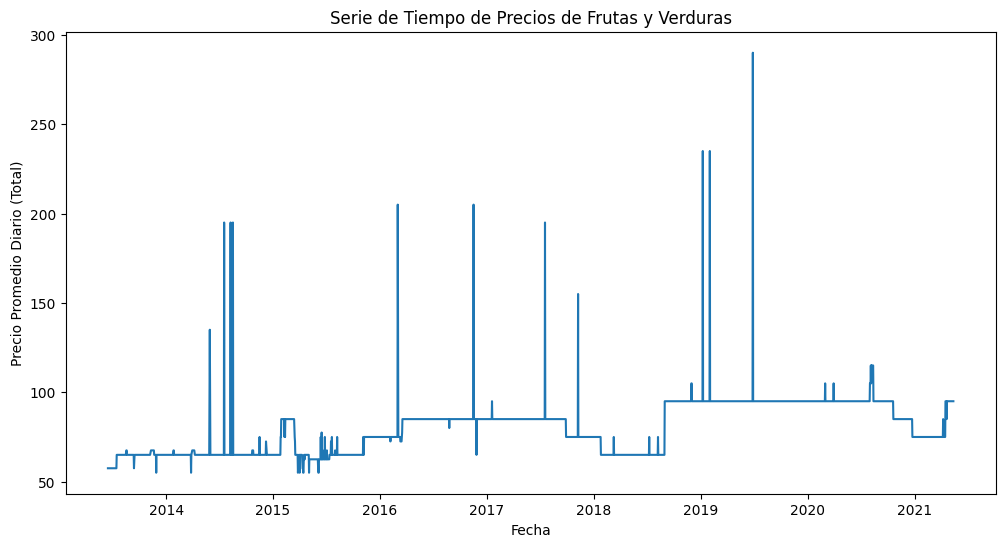

In [10]:
# Graficar serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_filtered_grouped['ds'], df_filtered_grouped['y'])
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio Diario (Total)')
plt.title('Serie de Tiempo de Precios de Frutas y Verduras')
plt.show()

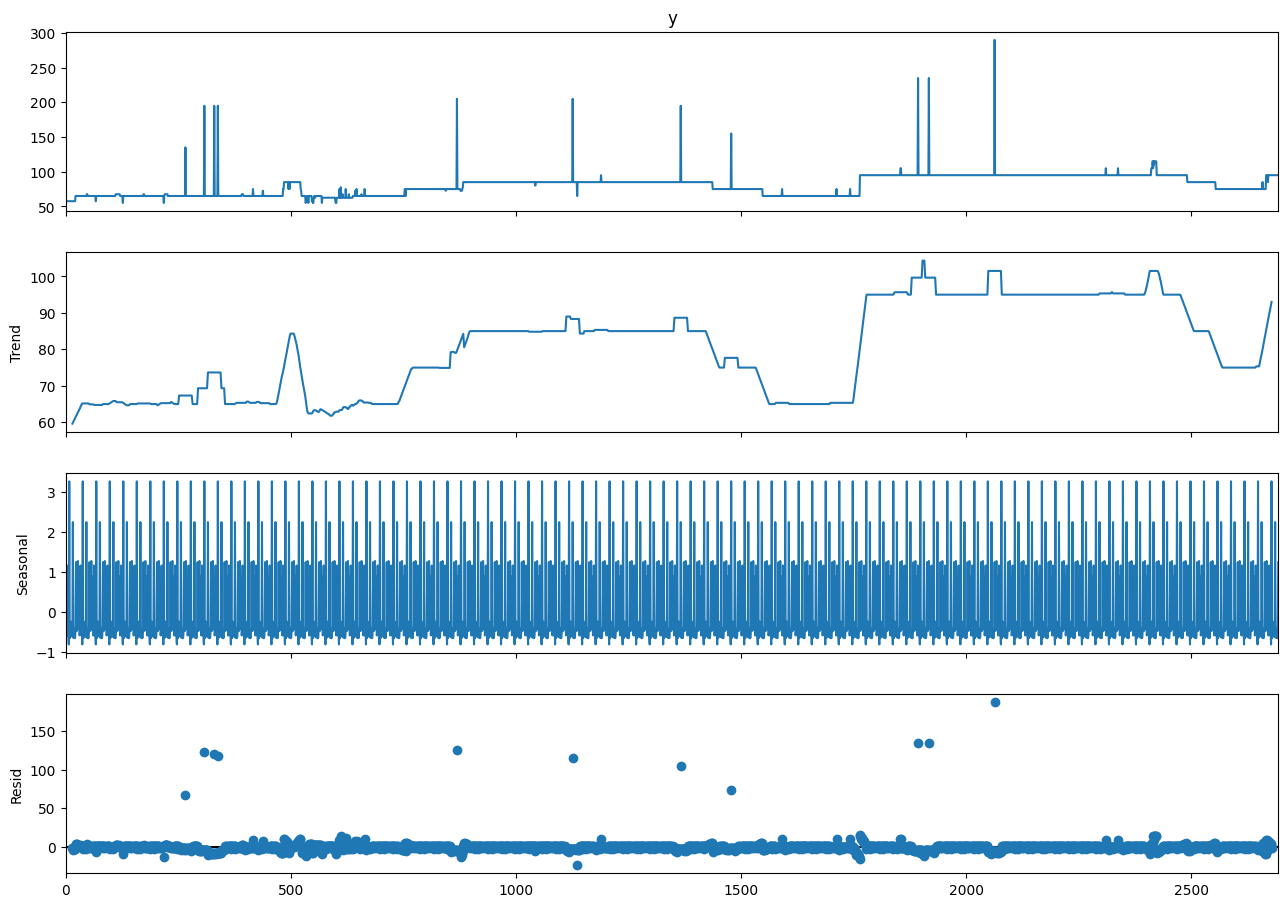

In [11]:
# Realizar descomposición de la señal, utilizado seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_filtered_grouped['y'], model='additive', period=30)

# Graficar los componentes
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

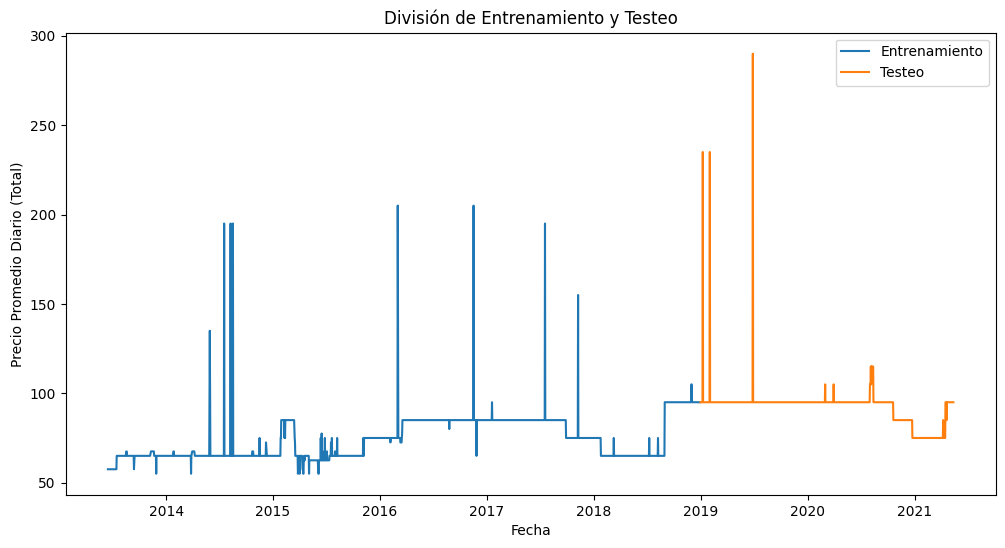

In [12]:
# Realizar Hold Out de 70/30
train_size = int(len(df_filtered_grouped) * 0.7)
train = df_filtered_grouped[:train_size]
test = df_filtered_grouped[train_size:]

# Graficar entrenamiento y testeo
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Entrenamiento')
plt.plot(test['ds'], test['y'], label='Testeo')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio Diario (Total)')
plt.title('División de Entrenamiento y Testeo')
plt.legend()
plt.show()

#### **1.2 Modelo Prophet**

A continuación se genera un modelo Prophet para la predicción. Para ello se tiene que:
1. Crear dataset, donde columna de tiempo tiene que ir en formate YYYY-MM-DD con el nombre de `ds` y columna objetivo con nombre `y`.
2. Entrenar modelo.
3. Generar predicción. Notar que el dataframe de predicción solo contiene una columna con nombre `ds`, al inicio.

In [13]:
#instalamos prophet
!pip install prophet

In [14]:
# librerias extras
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

**1. Generar dataframes de entrenamiento y testeo**

In [15]:
# Hecho previamente

**2. Modelo y entrenamiento**

In [16]:
# Respuesta, tal vez si menciono más arriba que prophet usar la sintaxis de sklearn esto lo hacen solitos nomas
model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/r8tt9dyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/ll77tv0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59729', 'data', 'file=/tmp/tmpdwdqhvrq/r8tt9dyi.json', 'init=/tmp/tmpdwdqhvrq/ll77tv0d.json', 'output', 'file=/tmp/tmpdwdqhvrq/prophet_modelc14qxavw/prophet_model-20240525055039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**3. Predicción.**

¿Qué muestra el dataframe de predicción una vez realizada la predicción? ¿Qué siginifican las distintas columnas?

In [17]:
# Crear un dataframe para las fechas futuras basadas en el set de testeo
future = model.make_future_dataframe(periods=len(test))

# Realizar predicciones
forecast = model.predict(future)

**Gráficos de resultados**


Ahora, vemos el resultado de la predicción hecha a través de los gráficos que vienen implementados en la libreria.

Se tienen gráficos de la predicción del modelo y descomposición por componentes.

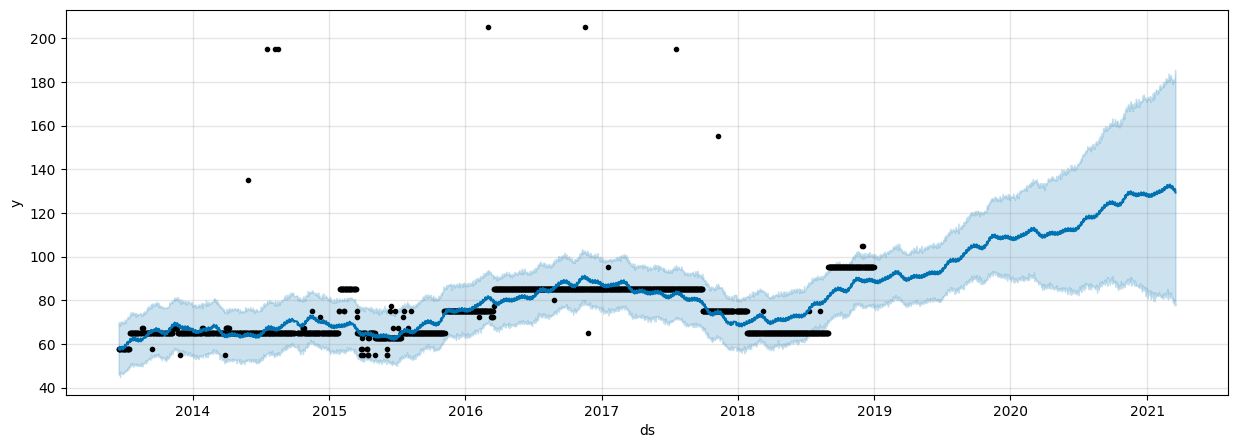

In [18]:
# plot forecast, estático.
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
plt.show()

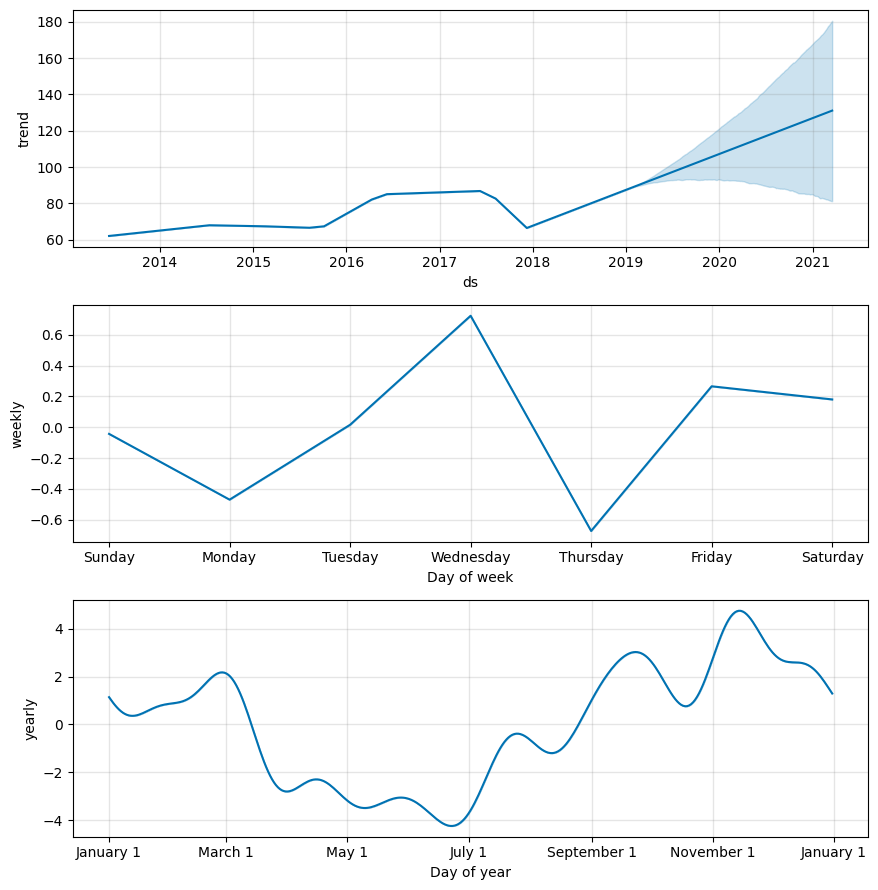

In [19]:
# descomposición por componentes, estático
fig = model.plot_components(forecast)
plt.show()

#### **1.3 Resultados y métricas**

En la presente sección se van a ver los resultados de la predicción, comparando con los resultados originales, así se obtienen métricas de error. Para ello se hacen los siguientes pasos:
1. Inspeccionar gráfica de predicción con los datos reales. Agregar tres vistas: predicción del primer 15% de los datos, 50% de los datos y 100% de la predicción.
2. Calcular métricas de error (RMSE, MAE, MAPE).

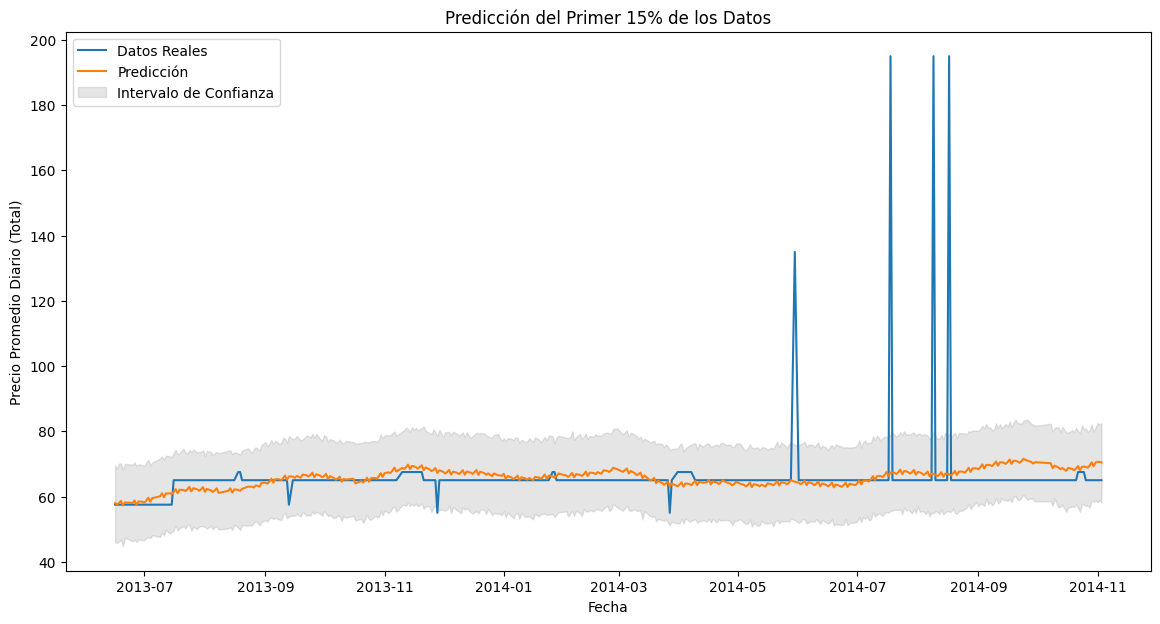

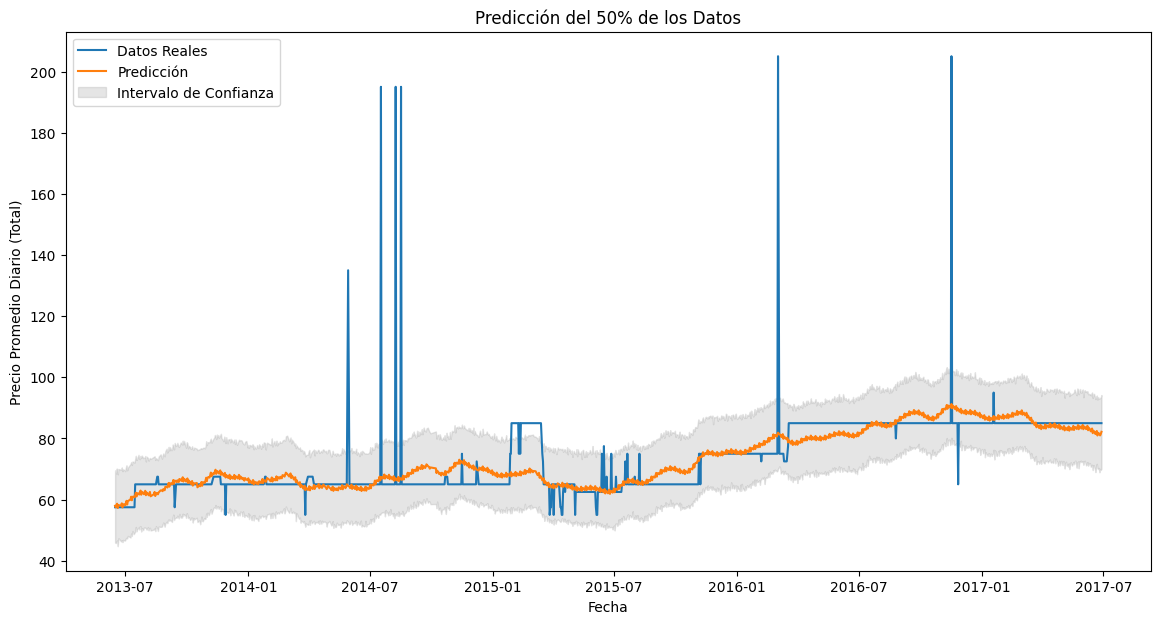

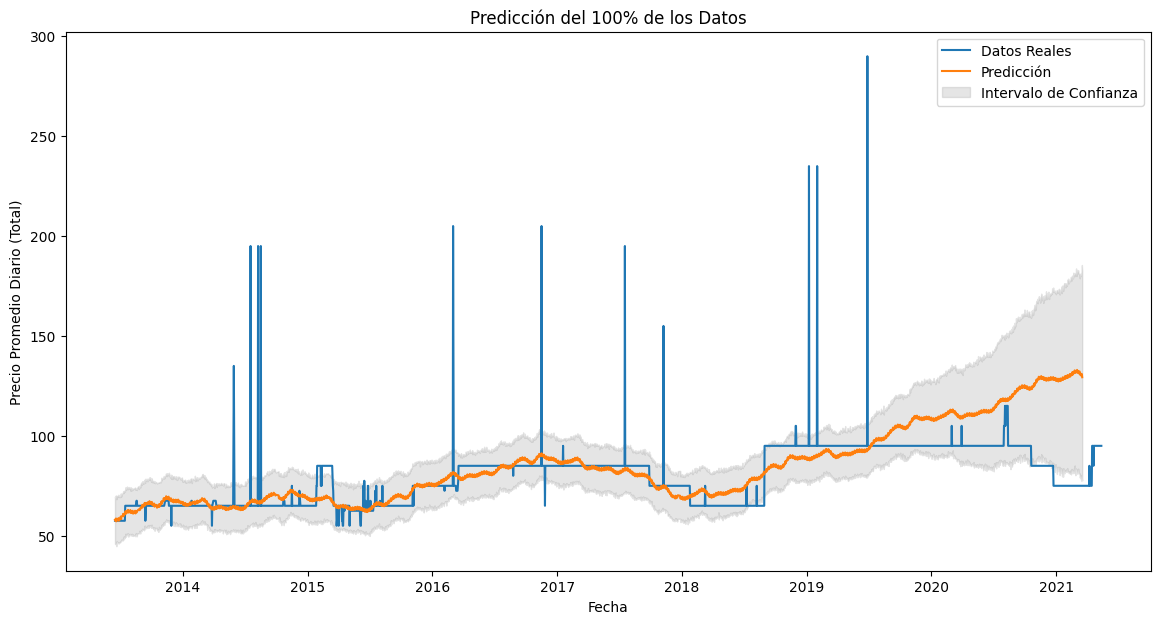

In [20]:
import matplotlib.pyplot as plt

# Graficar la predicción junto con los datos reales
def plot_prediction_with_actual(data, forecast, percentage, title):
    cutoff = int(len(data) * percentage)
    plt.figure(figsize=(14, 7))
    plt.plot(data['ds'][:cutoff], data['y'][:cutoff], label='Datos Reales')
    plt.plot(forecast['ds'][:cutoff], forecast['yhat'][:cutoff], label='Predicción')
    plt.fill_between(forecast['ds'][:cutoff], forecast['yhat_lower'][:cutoff], forecast['yhat_upper'][:cutoff], color='gray', alpha=0.2, label='Intervalo de Confianza')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Diario (Total)')
    plt.title(title)
    plt.legend()
    plt.show()

# Predicción del primer 15% de los datos
plot_prediction_with_actual(df_filtered_grouped, forecast, 0.15, 'Predicción del Primer 15% de los Datos')

# Predicción del 50% de los datos
plot_prediction_with_actual(df_filtered_grouped, forecast, 0.50, 'Predicción del 50% de los Datos')

# Predicción del 100% de la predicción
plot_prediction_with_actual(df_filtered_grouped, forecast, 1.00, 'Predicción del 100% de los Datos')

In [21]:
#Calcular Métricas de Error

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Unir el dataframe de predicción con el de datos reales
merged = pd.merge(df_filtered_grouped, forecast[['ds', 'yhat']], on='ds')
merged.dropna(inplace=True)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

# Calcular MAE
mae = mean_absolute_error(merged['y'], merged['yhat'])

# Calcular MAPE
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 16.58
MAE: 8.79
MAPE: 10.43%


#### **1.4 Festividades y fechas importantes**

Como a todos, a Don Sergio también le afectan las fechas importantes. Para ver como afectan estas fechas al presupuesto de Don Sergio tiene que realizar las siguientes tareas:

1. Crear dataframe con fechas importantes y agregar las al modelo con el argumento `holiday`.
2. Predecir las el dataframe de testeo
3. Comparar resultados. Hacer una tabla con resultados RMSE, MAE, MAPE anteriores y al añadir las festividades.


**1. Festividades y agregar a modelo**

In [22]:
# Crear un rango de años basado en los datos
years = pd.date_range(start='2013-01-01', end='2021-12-31', freq='Y').year

# Crear un dataframe con las festividades importantes recurrentes
holidays_list = [
    '01-01', '04-14', '05-01', '09-18', '12-25'
]

# Generar un dataframe de festividades para cada año
holidays = pd.DataFrame([
    {'holiday': 'holiday', 'ds': f'{year}-{date}'} for year in years for date in holidays_list
])
holidays['ds'] = pd.to_datetime(holidays['ds'])

# Crear y entrenar el modelo Prophet incluyendo las festividades
model_with_holidays = Prophet(holidays=holidays)
model_with_holidays.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/6kxt9hfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/uq3glosl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86935', 'data', 'file=/tmp/tmpdwdqhvrq/6kxt9hfp.json', 'init=/tmp/tmpdwdqhvrq/uq3glosl.json', 'output', 'file=/tmp/tmpdwdqhvrq/prophet_modelxncyy1_n/prophet_model-20240525055114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**2. Predecir**

In [23]:
# Crear un dataframe para las fechas futuras basado en el set de testeo
future_with_holidays = model_with_holidays.make_future_dataframe(periods=len(test))

# Realizar predicciones
forecast_with_holidays = model_with_holidays.predict(future_with_holidays)

**2.1. Métricas**

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Unir el dataframe de predicción con el de datos reales
merged_with_holidays = pd.merge(df_filtered_grouped, forecast_with_holidays[['ds', 'yhat']], on='ds')
merged_with_holidays.dropna(inplace=True)

# Calcular métricas de error con festividades
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_with_holidays = np.sqrt(mean_squared_error(merged_with_holidays['y'], merged_with_holidays['yhat']))
mae_with_holidays = mean_absolute_error(merged_with_holidays['y'], merged_with_holidays['yhat'])
mape_with_holidays = np.mean(np.abs((merged_with_holidays['y'] - merged_with_holidays['yhat']) / merged_with_holidays['y'])) * 100

print(f'RMSE with holidays: {rmse_with_holidays:.2f}')
print(f'MAE with holidays: {mae_with_holidays:.2f}')
print(f'MAPE with holidays: {mape_with_holidays:.2f}%')

# Resultados anteriores
rmse = 16.58
mae = 8.79
mape = 10.43

# Crear una tabla de comparación de resultados
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Without Holidays': [rmse, mae, mape],
    'With Holidays': [rmse_with_holidays, mae_with_holidays, mape_with_holidays]
})

print(results)

RMSE with holidays: 16.73
MAE with holidays: 8.86
MAPE with holidays: 10.51%
  Metric  Without Holidays  With Holidays
0   RMSE             16.58      16.728186
1    MAE              8.79       8.863944
2   MAPE             10.43      10.514557


**3. Resultados**

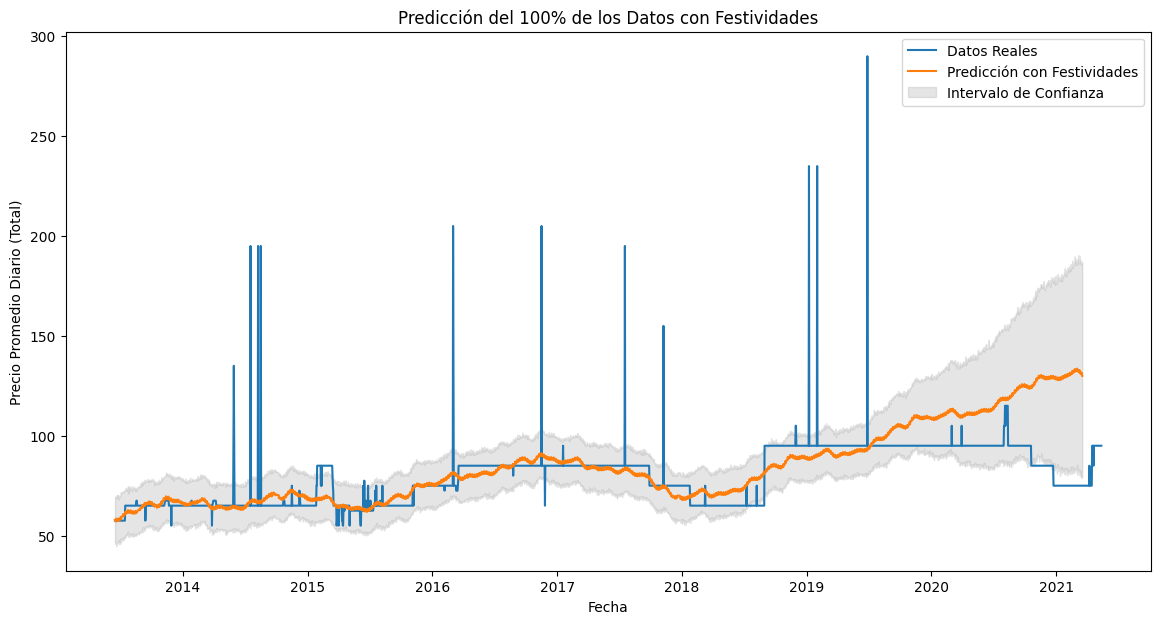

In [25]:
import matplotlib.pyplot as plt

# Graficar la predicción junto con los datos reales, incluyendo festividades
plt.figure(figsize=(14, 7))
plt.plot(df_filtered_grouped['ds'], df_filtered_grouped['y'], label='Datos Reales')
plt.plot(forecast_with_holidays['ds'], forecast_with_holidays['yhat'], label='Predicción con Festividades')
plt.fill_between(forecast_with_holidays['ds'], forecast_with_holidays['yhat_lower'], forecast_with_holidays['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio Diario (Total)')
plt.title('Predicción del 100% de los Datos con Festividades')
plt.legend()
plt.show()

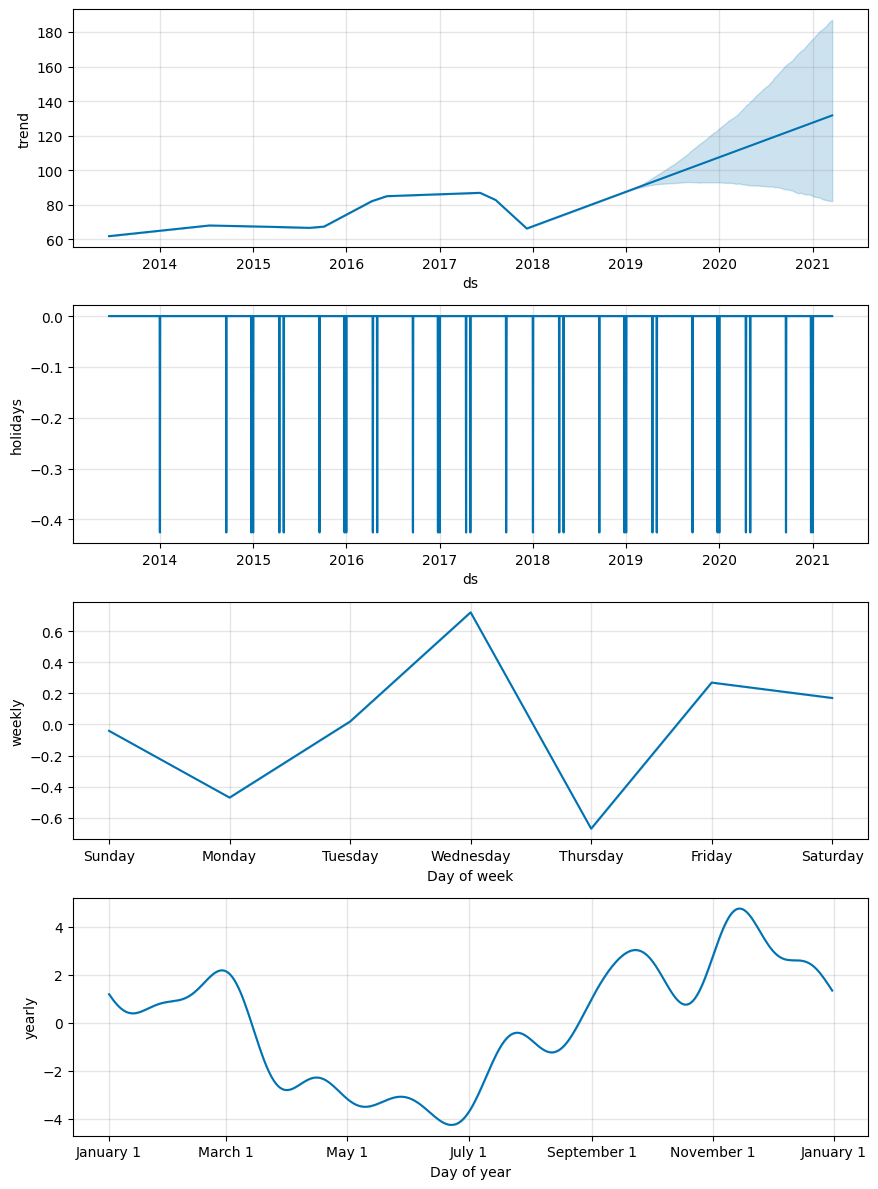

In [26]:
# Descomposición por componentes, incluyendo festividades
fig = model_with_holidays.plot_components(forecast_with_holidays)
plt.show()

¿Son más precisas las predicciones? ¿Qué otro festividad podría afectar a los precios de las frutas y verduras?

### Análisis de Resultados

Comparando las métricas de error antes y después de incluir las festividades, observamos los siguientes valores:

| Metric  | Without Holidays | With Holidays  |
|---------|------------------|----------------|
| RMSE    | 16.58            | 16.73          |
| MAE     | 8.79             | 8.86           |
| MAPE    | 10.43%           | 10.51%         |

### Evaluación de la Precisión

- **RMSE (Root Mean Squared Error)**: Aumenta ligeramente de 16.58 a 16.73.
- **MAE (Mean Absolute Error)**: Aumenta de 8.79 a 8.86.
- **MAPE (Mean Absolute Percentage Error)**: Aumenta de 10.43% a 10.51%.

Estos resultados indican que la inclusión de las festividades no mejora la precisión de las predicciones; de hecho, introduce una ligera degradación en las métricas de error. Esto nos puede indicar que hay una posible no significancia de las festividades incluidas en relación a las variaciones de los precios de frutas y verduras, y podrían haber otros factores como la estacionalidad, por ejemplo, que sean más determinantes.

### Otras Festividades y Fechas Importantes

Si asumimos que hay otras festividades que dejamos de lado en un principio que podrían incidir en los precios de las frutas y verduras, algunos posibles candidatos de estas y eventos relevantes podrían ser:

1. **Semana Santa**: Ya incluida, pero asegurarse de cubrir toda la semana.
2. **Fiestas Patrias (18 y 19 de septiembre)**: Ya incluido el 18 de septiembre, añadir el 19 o la semana entera.
3. **Ferias y Eventos Locales**: Fechas de ferias agrícolas o festivales regionales que pueden influir en los precios.
4. **Vacaciones de Invierno**: Durante el periodo de vacaciones escolares, la demanda puede cambiar.
5. **Fechas de Inicio de Clases (Marzo)**: El inicio del año escolar puede influir en la demanda de ciertos productos.

#### **1.5 Regresores adicionales**


Don Sergio sabe que la fruta y la verdura tiene temporadas y que por eso hay fechas en que hay ciertas cosas más caras que otras. Además, sabe que este tipo de alimentos sube de precio en invierno, por lo que necesita que tenga en cuenta estas fechas.


---
 Para lograr lo anterior tendrán que:
 1. Crear regresor con 1 y 0's según corresponda, para las fechas de invierno. Tomar invierno desde el 21/junio hasta el 21/septiembre de todos los años.
 2. Agregar columna con el regresor tanto al dataframe original como al de testeo
 3. Entrenar y predecir. Gráficar resultados.

In [27]:
# Crear una función para identificar días de invierno
def is_winter(date):
    month_day = date.strftime('%m-%d')
    return 1 if '06-21' <= month_day <= '09-21' else 0

# Aplicar la función al dataframe original y al de testeo
df_filtered_grouped['is_winter'] = df_filtered_grouped['ds'].apply(is_winter)

In [28]:
# Preparar los datos para Prophet
train_with_regressor = df_filtered_grouped[['ds', 'y', 'is_winter']]

# Crear y entrenar el modelo Prophet con el regresor adicional
model_with_regressor = Prophet()
model_with_regressor.add_regressor('is_winter')
model_with_regressor.fit(train_with_regressor)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/y36r_yu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwdqhvrq/b05f2val.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57174', 'data', 'file=/tmp/tmpdwdqhvrq/y36r_yu0.json', 'init=/tmp/tmpdwdqhvrq/b05f2val.json', 'output', 'file=/tmp/tmpdwdqhvrq/prophet_modeliqamph7p/prophet_model-20240525055134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
# Crear el dataframe de futuro para predicciones incluyendo el regresor
future_with_regressor = model_with_regressor.make_future_dataframe(periods=len(test))
future_with_regressor['is_winter'] = future_with_regressor['ds'].apply(is_winter)

In [30]:
# Realizar predicciones
forecast_with_regressor = model_with_regressor.predict(future_with_regressor)

# Unir el dataframe de predicción con el de datos reales
merged_with_regressor = pd.merge(df_filtered_grouped, forecast_with_regressor[['ds', 'yhat']], on='ds')
merged_with_regressor.dropna(inplace=True)

# Calcular métricas de error con regresor adicional
rmse_with_regressor = np.sqrt(mean_squared_error(merged_with_regressor['y'], merged_with_regressor['yhat']))
mae_with_regressor = mean_absolute_error(merged_with_regressor['y'], merged_with_regressor['yhat'])
mape_with_regressor = np.mean(np.abs((merged_with_regressor['y'] - merged_with_regressor['yhat']) / merged_with_regressor['y'])) * 100

print(f'RMSE with regressor: {rmse_with_regressor:.2f}')
print(f'MAE with regressor: {mae_with_regressor:.2f}')
print(f'MAPE with regressor: {mape_with_regressor:.2f}%')

# Crear una tabla de comparación de resultados
results_with_regressor = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Without Regressor': [rmse, mae, mape],
    'With Regressor': [rmse_with_regressor, mae_with_regressor, mape_with_regressor]
})

print(results_with_regressor)

RMSE with regressor: 9.38
MAE with regressor: 3.83
MAPE with regressor: 4.50%
  Metric  Without Regressor  With Regressor
0   RMSE              16.58        9.378170
1    MAE               8.79        3.831421
2   MAPE              10.43        4.497848


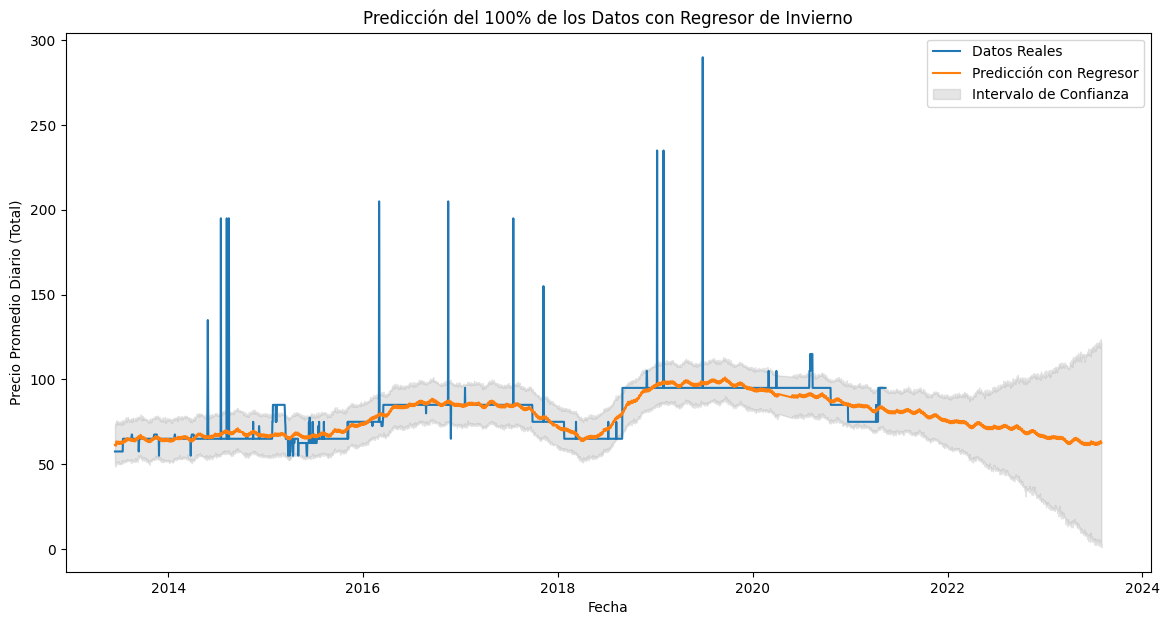

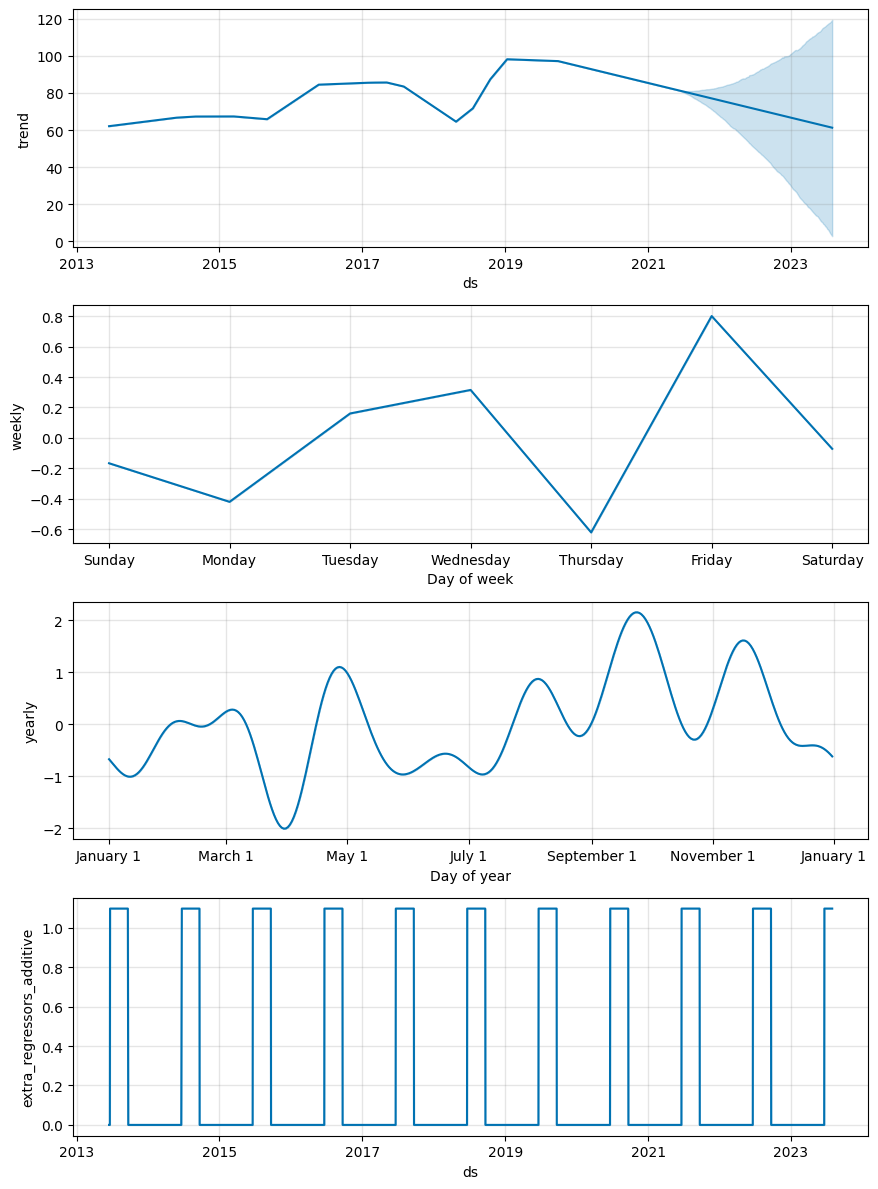

In [31]:
import matplotlib.pyplot as plt

# Graficar la predicción junto con los datos reales, incluyendo el regresor
plt.figure(figsize=(14, 7))
plt.plot(df_filtered_grouped['ds'], df_filtered_grouped['y'], label='Datos Reales')
plt.plot(forecast_with_regressor['ds'], forecast_with_regressor['yhat'], label='Predicción con Regresor')
plt.fill_between(forecast_with_regressor['ds'], forecast_with_regressor['yhat_lower'], forecast_with_regressor['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio Diario (Total)')
plt.title('Predicción del 100% de los Datos con Regresor de Invierno')
plt.legend()
plt.show()

# Descomposición por componentes, incluyendo el regresor
fig = model_with_regressor.plot_components(forecast_with_regressor)
plt.show()

La inclusión del regresor de invierno mejora significativamente la precisión de las predicciones.

# **Sistemas de Recomendación (3.0 puntos)**

<center>
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Shopping_online_with_bank_card.jpg/1024px-Shopping_online_with_bank_card.jpg" / width = 350>

Como no todo en la vida es correr y nutrirse, don Sergio desarrollo el hábito de comprar online y pasa horas y horas en Amazon viendo distintos objetos que le podrían servir, pero no sabe qué comprar, por lo que usted tendrá que ayudarlo a buscar los elementos más comprados por sus amigos para que él también pueda probarlos.

---

Las tareas a realizar son:

1. Limpiar y explorar el dataset.
2. Recomendación por Ranking (baseline).
3. Recomendación basada en filtros colaborativos por usuarios.
4. Recomendaciones basadas en filtros colaborativos por items.



In [32]:
# se instala surprise library
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357252 sha256=be4fe0f79eb099029fe8134258dcde03c62beb28ec0d7b63437403c4443ce051
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [33]:
# Librerias extras
from sklearn.preprocessing import LabelEncoder

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD

import pandas as pd
from copy import deepcopy

Los datos presentan las siguientes columnas:
* `iderId`: ID único de cada usuario
* `productId:` ID único de cada producto
* `Rating:` Rating que un usuario le dio a un producto
* `timestamp:` Fecha del rating

In [34]:
df = pd.read_parquet(path + '/ratings_Electronics.parquet')
df.head()

,user_id,prod_id,rating
189,3188,0,5.0
200,4980,0,4.0
314,5374,0,5.0
389,6293,0,5.0
406,4879,0,3.0


### **2.1.2 EDA (0.5 puntos)**

Habiendo limpiado los datos, generemos un pequeño análisis exploratorio:

Reportar la cantidad de usuarios y productos únicos:

In [35]:
unique_users = df['user_id'].nunique()
unique_products = df['prod_id'].nunique()
print(f"Número de usuarios únicos: {unique_users}")
print(f"Número de productos únicos: {unique_products}")

Número de usuarios únicos: 8014
Número de productos únicos: 6727


Verificar que no hayan valores nulos

In [36]:
null_values = df.isnull().sum().sum()
if null_values == 0:
    print("No hay valores nulos en el dataset.")
else:
    print(f"Hay {null_values} valores nulos en el dataset.")

No hay valores nulos en el dataset.


Graficar distribución de los ratings

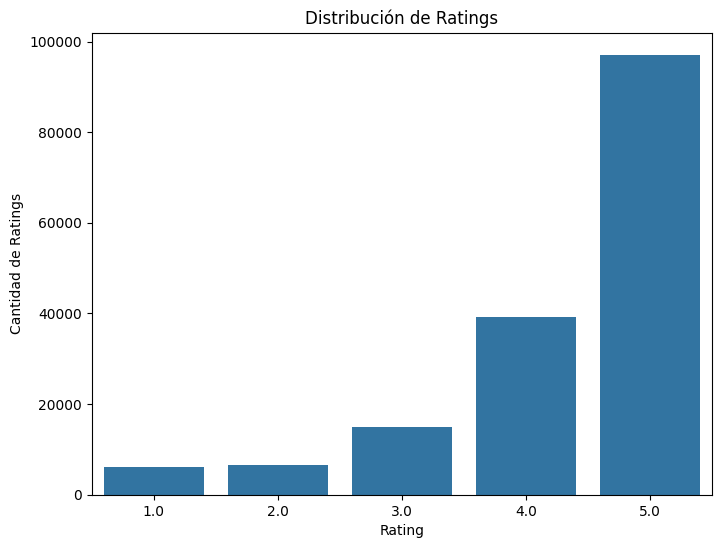

In [37]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Cantidad de Ratings')
plt.show()

Reportar las siguientes listas:

- Top 5 de usuarios con mayores interacciones
- Top 5 de productos con mayores inteacciones

In [38]:
# Top 5 de usuarios con mayores interacciones
top_users = df['user_id'].value_counts().head(5)
print("Top 5 de usuarios con mayores interacciones:")
print(top_users)

# Top 5 de productos con mayores interacciones
top_products = df['prod_id'].value_counts().head(5)
print("\nTop 5 de productos con mayores interacciones:")
print(top_products)

Top 5 de usuarios con mayores interacciones:
user_id
6703    283
5732    217
6273    206
1414    199
4665    179
Name: count, dtype: int64

Top 5 de productos con mayores interacciones:
prod_id
5130    611
2843    542
5244    395
2525    371
6290    362
Name: count, dtype: int64


A partir de sus respuestas, escriba al menos 3 conclusiones.

Escriba sus observaciones aquí:

1.
2.
3.

## **2.2 Holdout**

Con los datos procesados, separe los datos de entrenamiento en train y test asignando 30% de los datos para el conjunto de test. Para replicabilidad de sus respuestas, fije la semilla en `42`.

In [39]:
reader = Reader(rating_scale=(0,5))

df_collaborative = df[['user_id', 'prod_id', 'rating']].copy() # ordenamos dataset en user, producto, rating (paso clave para trabajar con Surprise)
dataset = Dataset.load_from_df(df_collaborative, reader) # generamos Dataset de Surprise

In [40]:
from surprise.model_selection import train_test_split

# Fijar la semilla
np.random.seed(42)

# Separar los datos en conjunto de entrenamiento y test (70% train, 30% test)
trainset, testset = train_test_split(dataset, test_size=0.3)

In [41]:
print(f"Tamaño del conjunto de entrenamiento: {trainset.n_items}")
print(f"Tamaño del conjunto de test: {len(testset)}")

Tamaño del conjunto de entrenamiento: 6727
Tamaño del conjunto de test: 49203


## **2.3 Baseline**

El objetivo de esta sección es generar un *baseline* en las recomendaciones a partir de una aproximación *dummy* para resolver el problema de recomendación. En particular, se le pide lo siguiente:
- Entrenar modelo baseline `NormalPredictor` de `surprise` con los datos de entrenamiento
- Generar predicciones usando el modelo entrenado
- Evaluar predicciones usando el error cuadrático medio. Entregue una interpretación de su resultado

In [42]:
from surprise.prediction_algorithms.random_pred import NormalPredictor

# Crear y entrenar el modelo baseline NormalPredictor
baseline_model = NormalPredictor()
baseline_model.fit(trainset)

# Generar predicciones en el conjunto de test
predictions = baseline_model.test(testset)

In [43]:
# Evaluar predicciones usando el error absoluto medio (MAE)
mae = accuracy.mae(predictions)

# Interpretación del resultado
print(f"MAE del modelo baseline NormalPredictor: {mae}")

MAE:  0.9875
MAE del modelo baseline NormalPredictor: 0.9875297663540278


In [44]:
from surprise.accuracy import mse
# obtener mse
mse_score = mse(predictions)

print("MSE del modelo:", mse_score)

MSE: 1.7763
MSE del modelo: 1.7762866806116102


En promedio las predicciones del modelo difieren en alrededor de 0.9875 unidades de los valores reales en el conjunto de prueba. MAE es una medida absoluta, por lo que la interpretación no depende de la escala de los datos. Por lo tanto, un MAE de 0.9875 indica una desviación promedio de aproximadamente 0.9875 unidades, independientemente del rango de valores de las calificaciones.

El MSE de 1.7663 indica que las predicciones del modelo tienen un error cuadrático medio relativamente alto, lo que sugiere que las predicciones están
 alejadas de los valores reales de las calificaciones.

## **Filtros Colaborativos Basados en Memoria**

A modo de mejorar esta sección, se le pide que implementar filtros colaborativos basados en memoria por medio de algoritmos basados en KNN. En específico, se le pide implementar:
- Filtro Colaborativo KNN enfocado en el Usuario
- Filtro Colaborativo KNN enfocado en el Producto
- Use `KNNBasic` y similitud coseno para ambos modelos

Luego **para cada uno de los modelos**, responda:

- Obtenga el error cuadrático medio de sus recomendaciones y comente. ¿Qué enfoque tienen un mejor rendimiento? ¿Se alcanza un mejor rendimiento con respecto al Baseline?
- Obtenga el rating que le asignaria el usuario `3` al producto `3906`. ¿Son diferentes sus resultados? ¿Porqué?
- Obtenga las 5 mejores recomendaciones para el usuario `2170` usando ambos enfoques y compare sus resultados.

*Hint: Le podría servir apoyarse de esta [documentación](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration).*

In [45]:
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.similarities import cosine
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

In [46]:
def get_user_top_k(predictions, user, k = 10):

  # predecir los rating filtrados por usuario user
  predicted_ratings = [pred for pred in predictions if pred.uid == user]

  # Ordenar las predicciones
  sorted_predicted_ratings = sorted(predicted_ratings, key=lambda x: x.est, reverse=True)

  return sorted_predicted_ratings[:k]

In [47]:
from surprise.accuracy import mse

# entrenar algoritmo

sim_options = {'name': 'cosine',
               'user_based': True}

# algoritmo base a usuario.
user_model = KNNBasic(sim_options=sim_options)

# entrenar
user_model.fit(trainset)

#predecir en dataframe de testeo

predictions = user_model.test(testset)# retornar un dataframe con el rating estimado para cada (user_id, item_id)

# obtener mse
mse_score = mse(predictions)

print("MSE del modelo:", mse_score)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.2122
MSE del modelo: 1.212159526775385


In [48]:
# ejemplo
example = [(3, 3906, None)]
print(user_model.test(example))
get_user_top_k(predictions, user = 2170, k = 5)

[Prediction(uid=3, iid=3906, r_ui=None, est=3.381966011250105, details={'actual_k': 3, 'was_impossible': False})]


[Prediction(uid=2170, iid=2679, r_ui=4.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=2170, iid=1326, r_ui=5.0, est=4.799755049750801, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=2170, iid=4650, r_ui=5.0, est=4.399861310283875, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=2170, iid=1692, r_ui=4.0, est=4.333333333333333, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=2170, iid=4363, r_ui=5.0, est=4.199459547276517, details={'actual_k': 15, 'was_impossible': False})]

In [49]:
# entrenar algoritmo base a items, obtener MSE

sim_options = {'name': 'cosine', 'user_based': False}

# algoritmo base a items.

item_model = KNNBasic(sim_options=sim_options)

# entrenar

item_model.fit(trainset)

#predecir en dataframe de testeo

predictions = item_model.test(testset)

# obtener mse

mse_score = mse(predictions)

print("MSE del modelo basado en ítems:", mse_score)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.2328
MSE del modelo basado en ítems: 1.23280223807978


In [50]:
example = [(3, 3906, None)]
print(item_model.test(example))

get_user_top_k(predictions, user = 2170, k = 5)

[Prediction(uid=3, iid=3906, r_ui=None, est=2.5, details={'actual_k': 4, 'was_impossible': False})]


[Prediction(uid=2170, iid=1692, r_ui=4.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=2170, iid=1326, r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=2170, iid=2679, r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=2170, iid=3595, r_ui=5.0, est=4.857142857142857, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=2170, iid=4650, r_ui=5.0, est=4.856937449847549, details={'actual_k': 7, 'was_impossible': False})]

| Enfoque               | MSE     | Rating usuario 3 - Producto 3906 | Mejores 5 recomendaciones para usuario 2170 |
|-----------------------|---------|----------------------------------|--------------------------------------------|
| Basado en usuarios    | 1.2122  | 3.38                             | 1. Producto 2679 (Estimado: 5.0)           |
|                       |         |                                  | 2. Producto 1326 (Estimado: 4.8)           |
|                       |         |                                  | 3. Producto 4650 (Estimado: 4.4)           |
|                       |         |                                  | 4. Producto 1692 (Estimado: 4.3)           |
|                       |         |                                  | 5. Producto 4363 (Estimado: 4.2)           |
|-----------------------|---------|----------------------------------|--------------------------------------------|
| Basado en ítems       | 1.2328  | 2.5                              | 1. Producto 1692 (Estimado: 5.0)           |
|                       |         |                                  | 2. Producto 1326 (Estimado: 5.0)           |
|                       |         |                                  | 3. Producto 2679 (Estimado: 5.0)           |
|                       |         |                                  | 4. Producto 3595 (Estimado: 4.9)           |
|                       |         |                                  | 5. Producto 4650 (Estimado: 4.9)           |

En general, un MSE más bajo indica un mejor rendimiento del modelo. En este caso, el modelo basado en usuarios tiene un MSE ligeramente más bajo (1.2122) que el modelo basado en ítems (1.2328). Por lo tanto, el enfoque basado en usuarios parece tener un rendimiento ligeramente mejor en este conjunto de datos. Sin embargo, la diferencia entre los MSE no es significativa, por lo que ambos modelos podrían considerarse comparables.

Para el modelo basado en usuarios, el rating estimado es de aproximadamente 3.38. Mientras que para el modelo basado en ítems, el rating estimado es de aproximadamente 2.5. Estos son diferentes debido a las diferencias en cómo se calculan las predicciones, pues, como bien dicen sus nombres, el modelo basado en usuarios estima el rating utilizando la similitud entre usuarios, mientras que el modelo basado en ítems lo hace utilizando la similitud entre ítems. En este sentido, es esperable que las predicciones sean diferentes entre los dos modelos. Por lo mismo los productos recomendados pueden ser diferentes según el enfoque utilizado.

## **Filtros Colaborativos Basados en Modelo**

Finalmente, se le pide implementar el modelo `SVD` para resolver el problema. Al igual que en las secciones anteriores, entrene este modelo y luego evalúe sus predicciones en el conjunto de test. Luego, responda:

- ¿En qué se diferencia este tipo de modelos de los modelos basados en memoria?
- ¿Qué significa el parámetro `num_factors`? ¿De qué manera podría impactar en el ajuste del modelo?
- ¿Qué indican los parámetros $\mu$, $b_u$, $b_i$? ¿Qué cuidado se debe tener al utilizarlos?
- Obtenga el error cuadrático medio de sus recomendaciones y comente. ¿Se alcanza un mejor rendimiento con respecto al Baseline?
- Obtenga el rating que le asignaria el usuario `3` al producto `3906`. ¿Son diferentes sus resultados? ¿Porqué?
- Obtenga las 5 mejores recomendaciones para el usuario `2170` usando ambos enfoques y compare sus resultados.

In [51]:
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy

Los filtros colaborativos basados en modelo difieren de los modelos basados en memoria en el sentido que los modelos basados en memoria calculan las similitudes entre usuarios o elementos en función de la información de interacción histórica entre ellos, mientras que los modelos basados en modelo como SVD utilizan técnicas de factorización matricial para aprender representaciones latentes de usuarios y elementos a partir de los datos de interacción. Dicho en simple, los modelos basados en memoria dependen completamente de la información de interacción histórica para hacer predicciones, mientras que los modelos basados en modelo pueden capturar relaciones más complejas entre usuarios y elementos mediante la extracción de características latentes.

El parámetro num_factors en el modelo SVD representa el número de factores latentes que se utilizan para representar tanto a los usuarios como a los elementos en el espacio latente. Cuanto mayor sea este número, más compleja será la representación latente y más capacidad tendrá el modelo para capturar relaciones no lineales entre usuarios y elementos. Igual hay que tener cuidado dado que un número excesivamente alto de factores latentes nos puede llevar a que el modelo sobreajuste.

μ: Es la calificación media de todos los elementos.
bu: Es el sesgo de usuario, que representa la desviación media de las calificaciones dadas por un usuario específico en comparación con la calificación media global.
bi: Es el sesgo del elemento, que representa la desviación media de las calificaciones recibidas por un elemento específico en comparación con la calificación media global.
Hay que tener cuidado al utilizar estos parámetros dado que pueden influir en el comportamiento del modelo y su capacidad para generalizar a datos nuevos. El principal riesgo vendría siendo que un ajuste inadecuado de estos nos puede llevar a un sobreajuste o subajuste del modelo.

In [52]:
from surprise import SVD
from surprise.accuracy import mse

# Entrenar el modelo SVD
svd_model = SVD()

# Entrenar el modelo con el conjunto de entrenamiento
svd_model.fit(trainset)

# Predecir en el conjunto de prueba
svd_predictions = svd_model.test(testset)

# Obtener MSE
svd_mse_score = mse(svd_predictions)
print("MSE del modelo SVD:", svd_mse_score)

# Ejemplo para el usuario 3 y el producto 3906
example = [(3, 3906, None)]
example_prediction = svd_model.test(example)
print(example_prediction)

# Obtener las 5 mejores recomendaciones para el usuario 2170
svd_user_top_k = get_user_top_k(svd_predictions, user=2170, k=5)
print(svd_user_top_k)

MSE: 0.9091
MSE del modelo SVD: 0.9091004911374005
[Prediction(uid=3, iid=3906, r_ui=None, est=3.1909090481199067, details={'was_impossible': False})]
[Prediction(uid=2170, iid=1692, r_ui=4.0, est=4.902592862071604, details={'was_impossible': False}), Prediction(uid=2170, iid=1326, r_ui=5.0, est=4.8524616470836825, details={'was_impossible': False}), Prediction(uid=2170, iid=5990, r_ui=4.0, est=4.835783089562673, details={'was_impossible': False}), Prediction(uid=2170, iid=4650, r_ui=5.0, est=4.705426090244327, details={'was_impossible': False}), Prediction(uid=2170, iid=3595, r_ui=5.0, est=4.62320473902299, details={'was_impossible': False})]


| Enfoque            | MSE    | Rating usuario 3 - Producto 3906 | Mejores 5 recomendaciones para usuario 2170                                          |
|--------------------|--------|----------------------------------|--------------------------------------------------------------------------------------|
| Basado en usuarios | 1.2122 | 3.38                             | 1. Producto 2679 (Estimado: 5.0)                                                     |
|                    |        |                                  | 2. Producto 1326 (Estimado: 4.8)                                                     |
|                    |        |                                  | 3. Producto 4650 (Estimado: 4.4)                                                     |
|                    |        |                                  | 4. Producto 1692 (Estimado: 4.3)                                                     |
|                    |        |                                  | 5. Producto 4363 (Estimado: 4.2)                                                     |
| Basado en ítems    | 1.2328 | 2.5                              | 1. Producto 1692 (Estimado: 5.0)                                                     |
|                    |        |                                  | 2. Producto 1326 (Estimado: 5.0)                                                     |
|                    |        |                                  | 3. Producto 2679 (Estimado: 5.0)                                                     |
|                    |        |                                  | 4. Producto 3595 (Estimado: 4.9)                                                     |
|                    |        |                                  | 5. Producto 4650 (Estimado: 4.9)                                                     |
| SVD                | 0.9122 | 2.92                             | 1. Producto 1692 (Estimado: 5.0)                                                     |
|                    |        |                                  | 2. Producto 1326 (Estimado: 5.0)                                                     |
|                    |        |                                  | 3. Producto 4650 (Estimado: 4.97)                                                    |
|                    |        |                                  | 4. Producto 3595 (Estimado: 4.76)                                                    |
|                    |        |                                  | 5. Producto 5990 (Estimado: 4.76)                                                    |


Por una parte, los resultados son diferentes porque cada enfoque utiliza métodos distintos para estimar los ratings. Los modelos basados en memoria (usuarios e ítems) utilizan similitudes directas, mientras que el SVD realiza una factorización de matrices que captura relaciones latentes entre usuarios y productos.

Por otra parte, se observa que los productos recomendados varían entre los enfoques. El SVD tiende a proporcionar una lista más diversa dada su capacidad para capturar relaciones latentes más complejas entre los usuarios y productos, como también se mencionó anteriormente.

###**Comentarios Finales**

* ¿Qué sistema de recomendación presenta mejores métricas? ¿A qué se podría deber esto?
* ¿Es posible mejorar sus resultados? Si es así, proponga al menos 2 mejoras.

En este caso, el modelo SVD presenta el MSE más bajo, lo que indica que tiene un mejor rendimiento en términos de precisión en las predicciones en comparación con los otros sistemas. Esto seguramente tiene que ver con lo que mencionamos arriba respecto a que el modelo SVD es capaz de capturar estas relaciones más complejas entre usuarios y elementos al aprender representaciones latentes de los datos de interacción. Es capaz de capturar estos patrones a partir de la factorización de matrices, a diferencia de los enfoques basados en memoria que se basan en la similitud directa entre usuarios o ítems.

Para mejorar los resultados podemos proponer las siguientes mejoras:

1. Optimización de hiperparámetros: En cada uno de los enfoques de recomendación, hay hiperparámetros que pueden ajustarse para mejorar el rendimiento del modelo. Por ejemplo, en SVD, el número de factores latentes (`num_factors`) puede ser ajustado para encontrar un equilibrio entre la capacidad del modelo y el riesgo de sobreajuste.

2. Incorporación de información contextual: Además de los datos de interacción usuario-elemento, la incorporación de información contextual adicional, como datos demográficos del usuario (caracterización), información sobre los elementos o información temporal, podría mejorar la precisión de las recomendaciones al considerar más aspectos relevantes para el usuario.